# TP - DNN

In [1]:
# Download the datasets if needed:
download = False
if download:
    import urllib.request
    urllib.request.urlretrieve("https://cs.nyu.edu/~roweis/data/mnist_all.mat", "mnist_all.mat")
    urllib.request.urlretrieve("https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat", "binaryalphadigs.mat")

In [2]:
# import libraries

# I use cupy to speed up the computation
# install with
# pip install cupy-cuda11x
# or
# pip install cupy-cuda12x
# based on the cuda version installed.

import utils
import matplotlib.pyplot as plt
import cupy as np
from copy import deepcopy
from sklearn.utils import shuffle

from models import RBM, DBN, DNN

np.random.seed(0)

## 4 Etude sur Binary AlphaDigit

On commance par vérifier un DBN entraîné est capable de générer des données dont la structure est semblable aux données d’apprentissage.

On propose un baseline à comparer:

- lettres: `A`, `B` et `C`
- hidden layers: [128]
- learning rate: 0.1
- nombre de itérations: 300
- batch size: 64

Training RBM(320, 64) layer 1/1:  52%|█████▏    | 157/300 [00:00<00:00, 181.16it/s, reconstruction_mse=0.0668]

Training RBM(320, 64) layer 1/1: 100%|██████████| 300/300 [00:01<00:00, 175.38it/s, reconstruction_mse=0.0503]


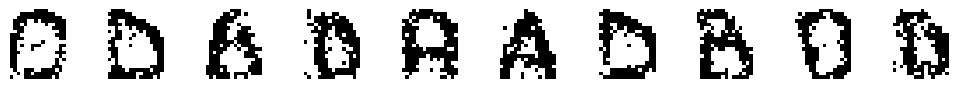

In [3]:
def set_baseline_hyperparams():
    global characters, data, n_visible, n_hidden, lr, nb_iter, batch_size

    characters = [10, 11, 12, 13]  # A B C D
    data = utils.lire_alpha_digit("binaryalphadigs.mat", characters)
    data = np.asarray(data)
    n_visible = [data.shape[1]]
    n_hidden = [64]
    lr = 0.1
    nb_iter = 300
    batch_size = 64

set_baseline_hyperparams()

dbn = DBN(n_visible + n_hidden)
dbn.train(data, lr=lr, batch_size=batch_size, nb_iter=nb_iter)

utils.show_images(dbn.generer_image(nb_iter_gibbs=100, nb_image=10), 10)

<div class="alert alert-block alert-info">
<b>Commentaire</b>

Le DBN entraîné est capable de générer des données dont la structure est semblable aux données d’apprentissage.

La qualité n'est pas très satisfiable pour ce modèle de baseline. On va étudier les hyperparamètres dans la suite.


### 4.1 Etude sur l'hyperparametre `nombre d’unités cachés`

On comparer la performance avec nombre d'unités cachés: [32,64,128,256]

Training with 32 hidden units


Training RBM(320, 32) layer 1/1: 100%|██████████| 300/300 [00:01<00:00, 190.13it/s, reconstruction_mse=0.0861]


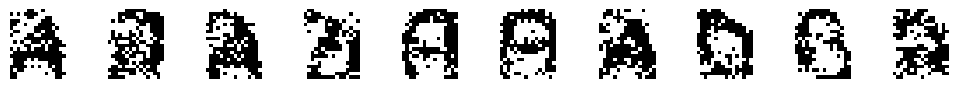

Training with 64 hidden units


Training RBM(320, 64) layer 1/1: 100%|██████████| 300/300 [00:01<00:00, 189.73it/s, reconstruction_mse=0.0508]


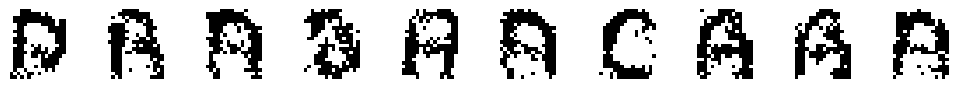

Training with 128 hidden units


Training RBM(320, 128) layer 1/1: 100%|██████████| 300/300 [00:01<00:00, 191.06it/s, reconstruction_mse=0.0194]


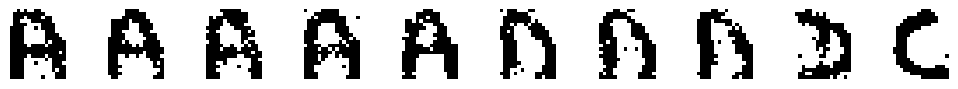

Training with 256 hidden units


Training RBM(320, 256) layer 1/1: 100%|██████████| 300/300 [00:01<00:00, 193.86it/s, reconstruction_mse=0.0044]


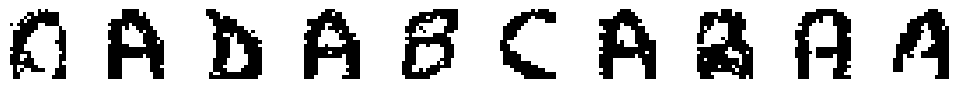

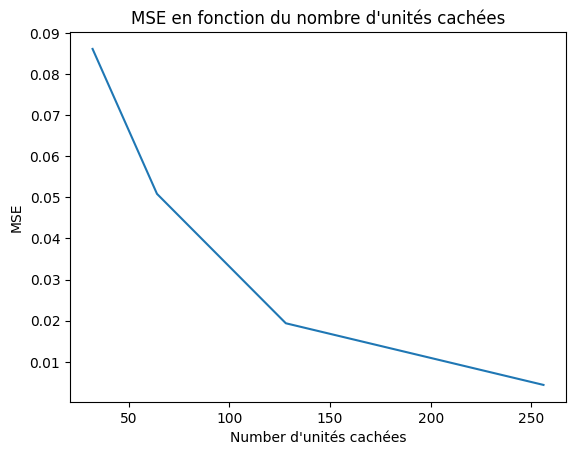

In [4]:
n_hidden_list = [32,64,128,256]
mse_list = []

for i in range(len(n_hidden_list)):
    set_baseline_hyperparams()
    n_hidden = [n_hidden_list[i]]
    print(f"Training with {n_hidden_list[i]} hidden units")

    dbn = DBN(n_visible + n_hidden)
    mse = dbn.train(data, lr=lr, batch_size=batch_size, nb_iter=nb_iter)
    mse_list.append(np.mean(np.array(mse)).get())

    utils.show_images(dbn.generer_image(nb_iter_gibbs=100, nb_image=10), 10)

plt.plot(n_hidden_list, mse_list)
plt.xlabel('Number d\'unités cachées')
plt.ylabel('MSE')
plt.title('MSE en fonction du nombre d\'unités cachées')
plt.show()

<div class="alert alert-block alert-info">
<b>Commentaire</b>

Plus il y a d'unités cachées, moins il y a l'errer de reconstuction, meilleure est la qualité de l'image générée.

### 4.2 Etude sur l'hyperparametre `nombre de couches cachées`

On comparer la performance avec nombre de couches cachées: [1,2,3,4]

Training with 1 hidden layers


Training RBM(320, 64) layer 1/1: 100%|██████████| 300/300 [00:01<00:00, 196.73it/s, reconstruction_mse=0.0515]


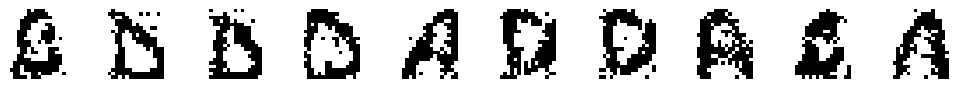

Training with 2 hidden layers


Training RBM(64, 64) layer 2/2: 100%|██████████| 300/300 [00:01<00:00, 198.66it/s, reconstruction_mse=0.0335]


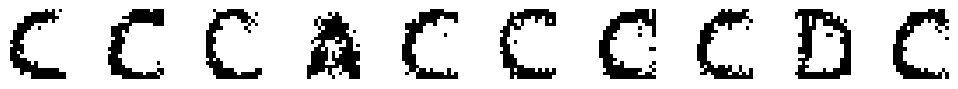

Training with 3 hidden layers


Training RBM(64, 64) layer 3/3: 100%|██████████| 300/300 [00:01<00:00, 194.45it/s, reconstruction_mse=0.0414]


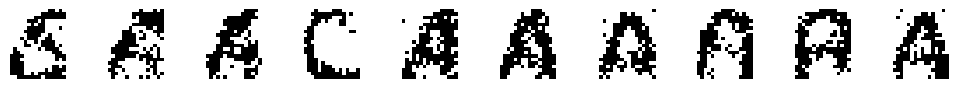

Training with 4 hidden layers


Training RBM(64, 64) layer 4/4: 100%|██████████| 300/300 [00:01<00:00, 196.00it/s, reconstruction_mse=0.0401]


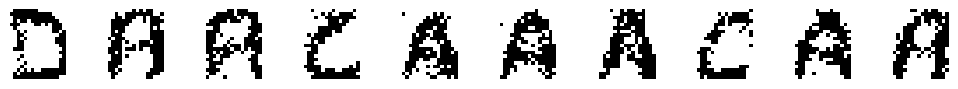

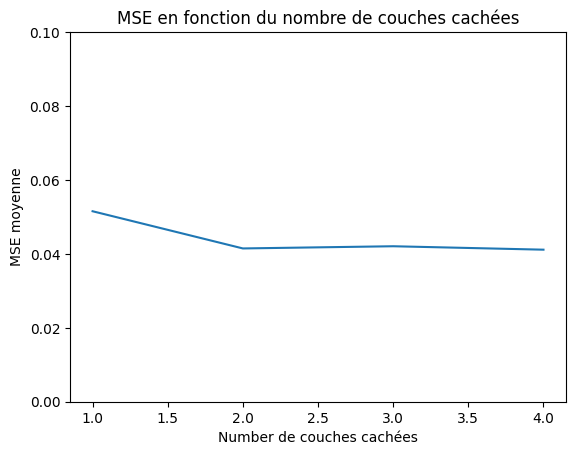

In [5]:
n_hidden_layers_list = [1,2,3,4]
mse_list = []

for i in range(len(n_hidden_layers_list)):
    set_baseline_hyperparams()
    n_hidden = [n_hidden[0]] * n_hidden_layers_list[i]
    print(f"Training with {n_hidden_layers_list[i]} hidden layers")

    dbn = DBN(n_visible + n_hidden)
    mse = dbn.train(data, lr=lr, batch_size=batch_size, nb_iter=nb_iter)
    mse_list.append(np.mean(np.array(mse)).get())

    utils.show_images(dbn.generer_image(nb_iter_gibbs=100, nb_image=10), 10)

plt.plot(n_hidden_layers_list, mse_list)
plt.xlabel("Number de couches cachées")
plt.ylabel("MSE moyenne")
plt.ylim([0, 0.1])
plt.title("MSE en fonction du nombre de couches cachées")
plt.show()

<div class="alert alert-block alert-info">
<b>Commentaire</b>

La qualité de reconstruction pour 2, 3, 4 couches cachées d'un DBN est meilleur que une seule RBM.

### 4.3 Etude sur l'hyperparametre `nombre de  caractères différents`

On comparer la performance avec nombre de  caractères différents: A-D, A-F, A-H

Training with 4 characters


Training RBM(320, 128) layer 1/1: 100%|██████████| 300/300 [00:01<00:00, 187.84it/s, reconstruction_mse=0.0194]


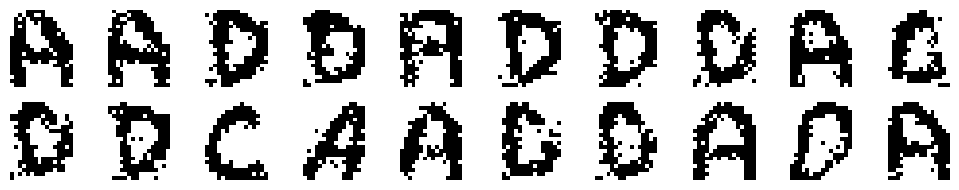

Training with 6 characters


Training RBM(320, 128) layer 1/1: 100%|██████████| 300/300 [00:01<00:00, 151.91it/s, reconstruction_mse=0.0218]


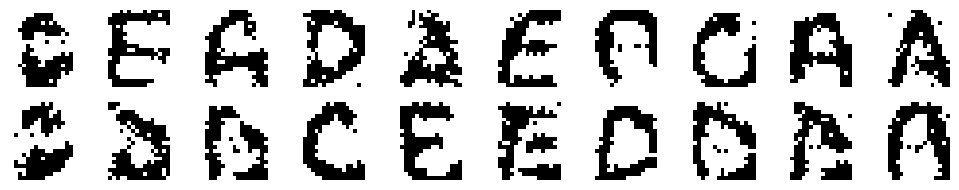

Training with 8 characters


Training RBM(320, 128) layer 1/1: 100%|██████████| 300/300 [00:02<00:00, 124.51it/s, reconstruction_mse=0.0244]


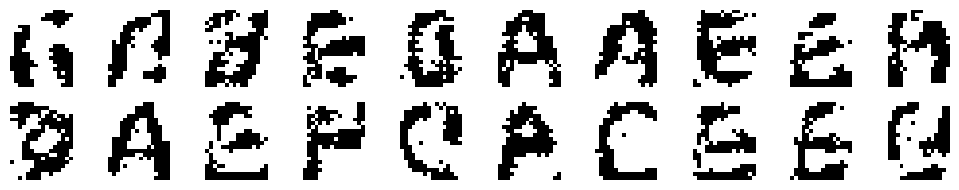

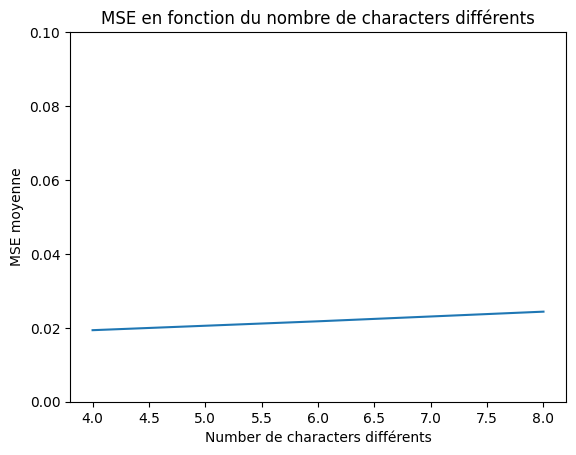

In [6]:
characters_list = [
    [10, 11, 12, 13],  # A, B, C, D
    [10, 11, 12, 13, 14, 15],  # A, B, C, D, E, F
    [10, 11, 12, 13, 14, 15, 16, 17],  # A, B, C, D, E, F, G, H
]
mse_list = []

for i in range(len(characters_list)):
    set_baseline_hyperparams()
    characters = characters_list[i]
    data = utils.lire_alpha_digit("binaryalphadigs.mat", characters)
    data = np.asarray(data)
    n_hidden = [128]
    print(f"Training with {len(characters)} characters")

    dbn = DBN(n_visible + n_hidden)
    mse = dbn.train(data, lr=lr, batch_size=batch_size, nb_iter=nb_iter)
    mse_list.append(np.mean(np.array(mse)).get())

    utils.show_images(dbn.generer_image(nb_iter_gibbs=100, nb_image=20), 10)

plt.plot([len(characters) for characters in characters_list], mse_list)
plt.xlabel("Number de characters différents")
plt.ylabel("MSE moyenne")
plt.ylim([0, 0.1])
plt.title("MSE en fonction du nombre de characters différents")
plt.show()

<div class="alert alert-block alert-info">
<b>Commentaire</b>

Plus il y a des caractères différents, plus il y a l'errer de reconstuction, moins meilleure est la qualité de l'image générée.

## 5 Étude à réaliser sur MNIST

Les hyperparamètres utilisés:

- batch_size = 128
- nb_iter_pretrain = 10
- nb_iter_train = 10
- lr_pretrain = 0.1
- lr_train = 0.1
- n_visible = [x.shape[1]]
- n_hidden = [128, 128, 10]

Start Pretraining.


Training RBM(784, 128) layer 1/2:   0%|          | 0/10 [00:00<?, ?it/s]

Training RBM(128, 128) layer 2/2: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s, reconstruction_mse=0.0430]


Reconstruction using pretrained DBN model.


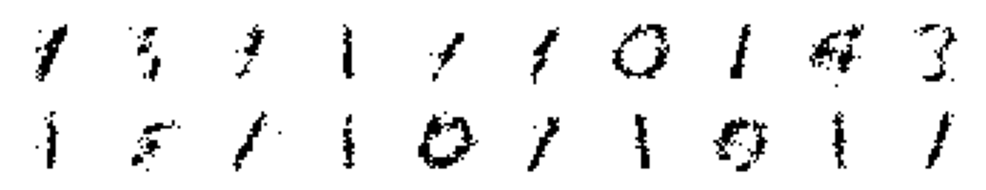

Start Training.


Iteration 10/10: 100%|██████████| 469/469 [00:02<00:00, 211.79it/s, accuracy=0.9358, loss=0.2234]


Start Testing.


100%|██████████| 79/79 [00:00<00:00, 449.70it/s, accuracy=0.9364, loss=0.2214]


0.9364121835443038

In [7]:
x, y = utils.lire_mnist_all("mnist_all.mat", train=True)
x = np.asarray(x)
y = np.asarray(y)

batch_size = 128
nb_iter_pretrain = 10
nb_iter_train = 10
lr_pretrain = 0.1
lr_train = 0.1
n_visible = [x.shape[1]]
n_hidden = [128, 128, 10]
dnn = DNN(n_visible + n_hidden)

print("Start Pretraining.")
dnn.pretrain(x, lr=lr_pretrain, batch_size=batch_size, nb_iter=nb_iter_pretrain)

print("Reconstruction using pretrained DBN model.")
utils.show_images(dnn.dbn.generer_image(nb_iter_gibbs=100, nb_image=20), 10, height=28, width=28)

print("Start Training.")
dnn.retropropagation(x, y, lr=lr_train, batch_size=batch_size, nb_iter=nb_iter_train)

print("Start Testing.")
x, y = utils.lire_mnist_all("mnist_all.mat", train=False)
x = np.asarray(x)
y = np.asarray(y)
dnn.test(x, y, batch_size, verbose=True)

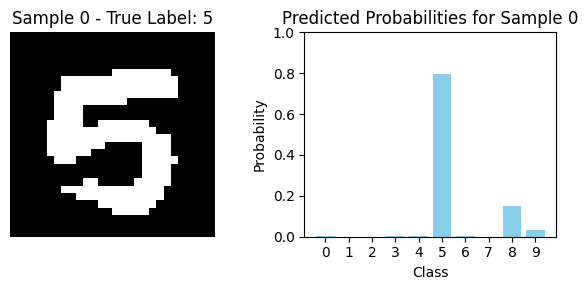

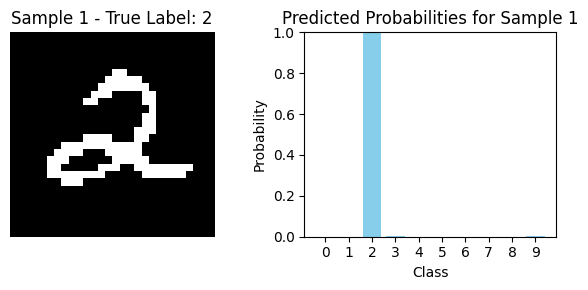

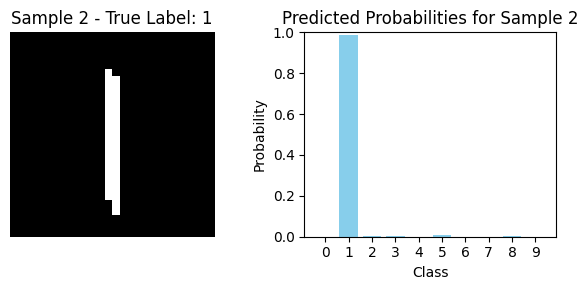

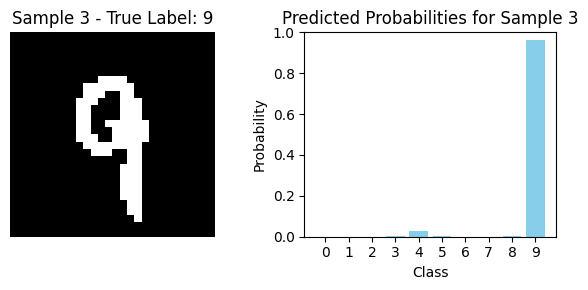

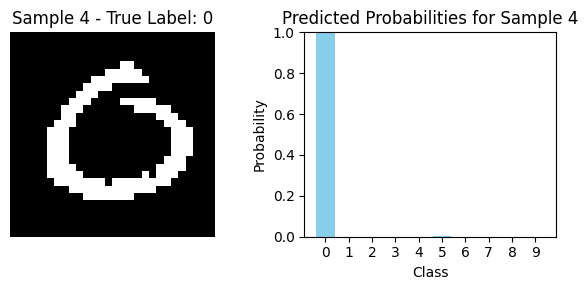

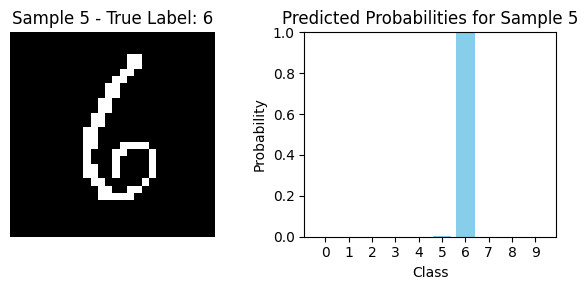

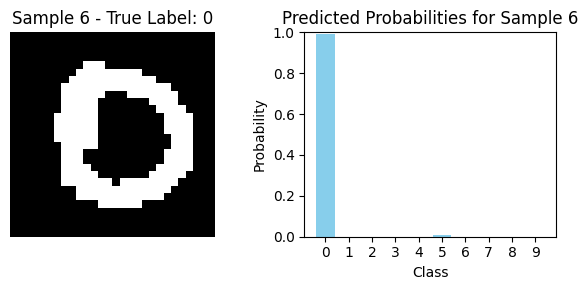

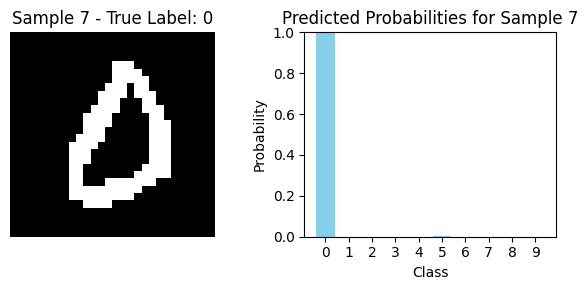

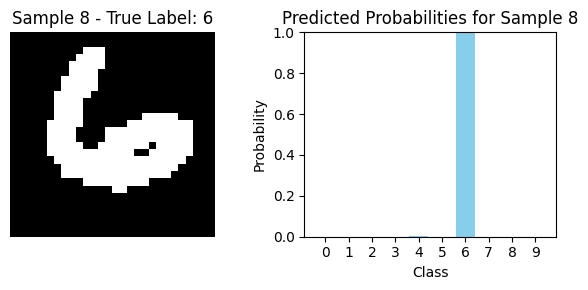

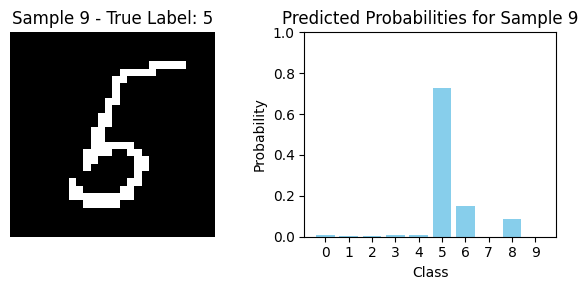

In [8]:
# Illustration of classification
x, y = utils.lire_mnist_all("mnist_all.mat", train=False)
x, y = shuffle(x, y)
x = np.asarray(x)
y = np.asarray(y)

nb_sample = 10
x_sample = x[0 : nb_sample]
y_sample = y[0 : nb_sample]
_, y_pred = dnn.entree_sortie_reseau(x_sample)
y_true = np.argmax(y_sample, axis=1)

for i in range(nb_sample):

    plt.figure(figsize=(6, 3))

    # draw sample image
    plt.subplot(1, 2, 1)
    plt.imshow(x_sample[i].reshape(28, 28).get(), cmap="gray") 
    plt.title(f"Sample {i} - True Label: {y_true[i]}")
    plt.axis("off")

    # draw predicted probabilities
    plt.subplot(1, 2, 2)
    plt.bar(range(10), y_pred[i].flatten().get(), tick_label=range(10), color="skyblue")
    plt.title(f"Predicted Probabilities for Sample {i}")
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.ylim(0, 1) 

    plt.tight_layout()
    plt.show()

### 5.2 Analyse


In [9]:
def set_baseline_hyperparams():
    global x, y, x_test, y_test, n_visible, n_hidden, lr_pretrain, lr_train, nb_iter_pretrain, nb_iter_train, nb_iter, batch_size
    x, y = utils.lire_mnist_all("mnist_all.mat", train=True)
    x = np.asarray(x)
    y = np.asarray(y)

    x_test, y_test = utils.lire_mnist_all("mnist_all.mat", train=False)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)

    batch_size = 128
    nb_iter_pretrain = 10
    nb_iter_train = 10
    lr_pretrain = 0.1
    lr_train = 0.1
    n_visible = [x.shape[1]]
    n_hidden = [128, 128, 10]

#### 5.2.1 Analyse en fonction de nombre de couches cachées.

2 courbes exprimant le taux d’erreur des 2 réseaux en fonction du nombre de couches ([128]*2, 3, 4, 5). On utilisera toutes les données d’apprentissage et test.

Training with 2 hidden layers except the last layer


acc_pretrained_trainset: 0.9357
acc_non_pretrained_trainset: 0.9227
acc_pretrained_testset: 0.9377
acc_non_pretrained_testset: 0.9232

--------------------------------------------------

Training with 3 hidden layers except the last layer
acc_pretrained_trainset: 0.9427
acc_non_pretrained_trainset: 0.9097
acc_pretrained_testset: 0.9453
acc_non_pretrained_testset: 0.9115

--------------------------------------------------

Training with 4 hidden layers except the last layer
acc_pretrained_trainset: 0.9465
acc_non_pretrained_trainset: 0.8757
acc_pretrained_testset: 0.9441
acc_non_pretrained_testset: 0.8705

--------------------------------------------------

Training with 5 hidden layers except the last layer
acc_pretrained_trainset: 0.9482
acc_non_pretrained_trainset: 0.2472
acc_pretrained_testset: 0.9476
acc_non_pretrained_testset: 0.2562

--------------------------------------------------



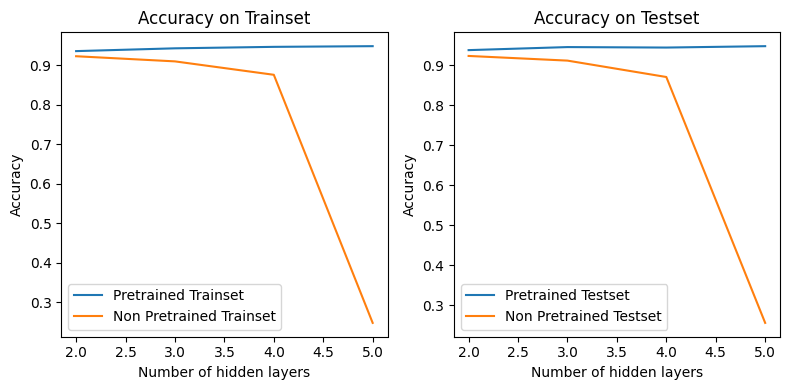

In [10]:
n_hidden_layers_list = [2, 3, 4, 5]

acc_pretrained_trainset_list = []
acc_non_pretrained_trainset_list = []
acc_pretrained_testset_list = []
acc_non_pretrained_testset_list = []

for i in range(len(n_hidden_layers_list)):
    set_baseline_hyperparams()
    n_hidden = [128] * n_hidden_layers_list[i] + [10]
    print(f"Training with {n_hidden_layers_list[i]} hidden layers except the last layer")

    dbn_pretrained = DNN(n_visible + n_hidden)
    dbn_non_pretrained = deepcopy(dbn_pretrained)

    # print("Start Pretraining dbn_pretrained")
    dbn_pretrained.pretrain(
        x,
        lr=lr_pretrain,
        batch_size=batch_size,
        nb_iter=nb_iter_pretrain,
        verbose=False,
    )

    # print("Start Training dbn_pretrained")
    acc_pretrained_trainset=dbn_pretrained.retropropagation(
        x, y, lr=lr_train, batch_size=batch_size, nb_iter=nb_iter_train, verbose=False
    )
    print(f"acc_pretrained_trainset: {acc_pretrained_trainset:.4f}")

    # print("Start Training dbn_non_pretrained")
    acc_non_pretrained_trainset = dbn_non_pretrained.retropropagation(
        x, y, lr=lr_train, batch_size=batch_size, nb_iter=nb_iter_train, verbose=False
    )
    print(f"acc_non_pretrained_trainset: {acc_non_pretrained_trainset:.4f}")

    # print("Start Testing dbn_pretrained")
    acc_pretrained_testset = dbn_pretrained.test(
        x_test, y_test, batch_size, verbose=False
    )
    print(f"acc_pretrained_testset: {acc_pretrained_testset:.4f}")

    # print("Start Testing dbn_non_pretrained")
    acc_non_pretrained_testset = dbn_non_pretrained.test(x_test, y_test, batch_size, verbose=False)
    print(f"acc_non_pretrained_testset: {acc_non_pretrained_testset:.4f}")

    acc_pretrained_trainset_list.append(acc_pretrained_trainset)
    acc_non_pretrained_trainset_list.append(acc_non_pretrained_trainset)
    acc_pretrained_testset_list.append(acc_pretrained_testset)
    acc_non_pretrained_testset_list.append(acc_non_pretrained_testset)

    print("\n"+"-"*50+"\n")


plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(n_hidden_layers_list, acc_pretrained_trainset_list, label="Pretrained Trainset")
plt.plot(n_hidden_layers_list, acc_non_pretrained_trainset_list, label="Non Pretrained Trainset")
plt.xlabel("Number of hidden layers")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy on Trainset")

plt.subplot(1, 2, 2)
plt.plot(n_hidden_layers_list, acc_pretrained_testset_list, label="Pretrained Testset")
plt.plot(n_hidden_layers_list, acc_non_pretrained_testset_list, label="Non Pretrained Testset")
plt.xlabel("Number of hidden layers")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy on Testset")

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<b>Commentaire</b>

1. Généralement, les modèles pré-entraînés + entraînés surpassent les modèles uniquement entraînés.
2. Avec la fonction d'activation sigmoid, on peut rencontrer le problème de disparition de gradient dans des réseaux profonds. Par conséquent, le modèle avec 5 couches cachées a échoué à être entraîné. Cependant, si on pré-entraîne le modèle comme un DBN, les couches peuvent apprendre une bonne représentation, ce qui les rend plus faciles à entraîner.

#### 5.2.2 Analyse en fonction de nombre de neurones par couches.

2 courbes exprimant le taux d’erreur des 2 réseaux en fonction du nombre de neurones par couches (2 couches avec [64, 128, 256, 512] neurones par couche). On utilisera toutes les données d’apprentissage et test.

Training with 64 hidden units per layer


acc_pretrained_trainset: 0.9150
acc_non_pretrained_trainset: 0.9172
acc_pretrained_testset: 0.9188
acc_non_pretrained_testset: 0.9157

--------------------------------------------------

Training with 128 hidden units per layer
acc_pretrained_trainset: 0.9389
acc_non_pretrained_trainset: 0.9208
acc_pretrained_testset: 0.9400
acc_non_pretrained_testset: 0.9203

--------------------------------------------------

Training with 256 hidden units per layer
acc_pretrained_trainset: 0.9484
acc_non_pretrained_trainset: 0.9223
acc_pretrained_testset: 0.9482
acc_non_pretrained_testset: 0.9201

--------------------------------------------------

Training with 512 hidden units per layer
acc_pretrained_trainset: 0.9598
acc_non_pretrained_trainset: 0.9224
acc_pretrained_testset: 0.9586
acc_non_pretrained_testset: 0.9218

--------------------------------------------------



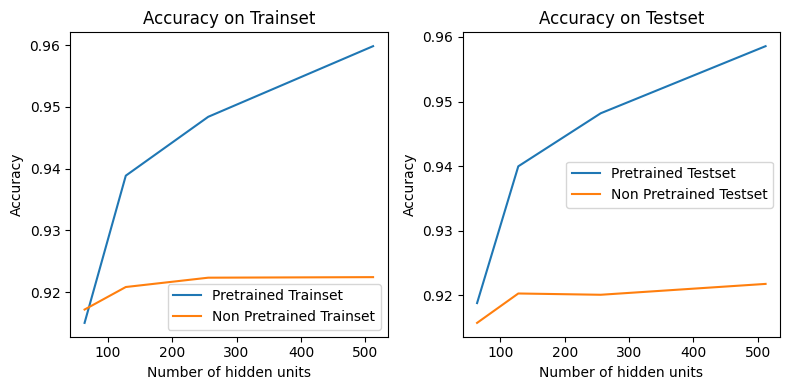

In [11]:
n_hidden_units = [64, 128, 256, 512]

acc_pretrained_trainset_list = []
acc_non_pretrained_trainset_list = []
acc_pretrained_testset_list = []
acc_non_pretrained_testset_list = []

for i in range(len(n_hidden_layers_list)):
    set_baseline_hyperparams()
    n_hidden = [n_hidden_units[i]] * 2 + [10]
    print(f"Training with {n_hidden_units[i]} hidden units per layer")

    dbn_pretrained = DNN(n_visible + n_hidden)
    dbn_non_pretrained = deepcopy(dbn_pretrained)

    # print("Start Pretraining dbn_pretrained")
    dbn_pretrained.pretrain(
        x,
        lr=lr_pretrain,
        batch_size=batch_size,
        nb_iter=nb_iter_pretrain,
        verbose=False,
    )

    # print("Start Training dbn_pretrained")
    acc_pretrained_trainset = dbn_pretrained.retropropagation(
        x, y, lr=lr_train, batch_size=batch_size, nb_iter=nb_iter_train, verbose=False
    )
    print(f"acc_pretrained_trainset: {acc_pretrained_trainset:.4f}")

    # print("Start Training dbn_non_pretrained")
    acc_non_pretrained_trainset = dbn_non_pretrained.retropropagation(
        x, y, lr=lr_train, batch_size=batch_size, nb_iter=nb_iter_train, verbose=False
    )
    print(f"acc_non_pretrained_trainset: {acc_non_pretrained_trainset:.4f}")

    # print("Start Testing dbn_pretrained")
    acc_pretrained_testset = dbn_pretrained.test(
        x_test, y_test, batch_size, verbose=False
    )
    print(f"acc_pretrained_testset: {acc_pretrained_testset:.4f}")

    # print("Start Testing dbn_non_pretrained")
    acc_non_pretrained_testset = dbn_non_pretrained.test(
        x_test, y_test, batch_size, verbose=False
    )
    print(f"acc_non_pretrained_testset: {acc_non_pretrained_testset:.4f}")

    acc_pretrained_trainset_list.append(acc_pretrained_trainset)
    acc_non_pretrained_trainset_list.append(acc_non_pretrained_trainset)
    acc_pretrained_testset_list.append(acc_pretrained_testset)
    acc_non_pretrained_testset_list.append(acc_non_pretrained_testset)

    print("\n" + "-" * 50 + "\n")


plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(n_hidden_units, acc_pretrained_trainset_list, label="Pretrained Trainset")
plt.plot(
    n_hidden_units,
    acc_non_pretrained_trainset_list,
    label="Non Pretrained Trainset",
)
plt.xlabel("Number of hidden units")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy on Trainset")

plt.subplot(1, 2, 2)
plt.plot(n_hidden_units, acc_pretrained_testset_list, label="Pretrained Testset")
plt.plot(
    n_hidden_units,
    acc_non_pretrained_testset_list,
    label="Non Pretrained Testset",
)
plt.xlabel("Number of hidden units")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy on Testset")

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<b>Commentaire</b>

1. Généralement, les modèles pré-entraînés + entraînés surpassent les modèles uniquement entraînés.
2. Les modèles pré-entraînés + entraînés bénéficient davantage d'un plus grand nombre de neurones, leur précision continue d'augmenter avec l'accroissement des neurones. Tandis que la précision des modèles uniquement entraînés augmente légèrement et ne change pas sur l'ensemble de test.

#### 5.2.3 Analyse en fonction de nombre de données train.

2 courbes exprimant le taux d’erreur des 2 réseaux en fonction du nombre de données train ([1000, 3000, 7000, 10000, 30000, 60000]).

Training with 1000 train samples
acc_pretrained_trainset: 1.0000
acc_non_pretrained_trainset: 1.0000
acc_pretrained_testset: 0.0969
acc_non_pretrained_testset: 0.0969

--------------------------------------------------

Training with 3000 train samples
acc_pretrained_trainset: 1.0000
acc_non_pretrained_trainset: 1.0000
acc_pretrained_testset: 0.0969
acc_non_pretrained_testset: 0.0969

--------------------------------------------------

Training with 7000 train samples
acc_pretrained_trainset: 0.9983
acc_non_pretrained_trainset: 0.9979
acc_pretrained_testset: 0.2086
acc_non_pretrained_testset: 0.2088

--------------------------------------------------

Training with 10000 train samples
acc_pretrained_trainset: 0.9970
acc_non_pretrained_trainset: 0.9974
acc_pretrained_testset: 0.2089
acc_non_pretrained_testset: 0.2089

--------------------------------------------------

Training with 30000 train samples
acc_pretrained_trainset: 0.9742
acc_non_pretrained_trainset: 0.9661
acc_pretrained_te

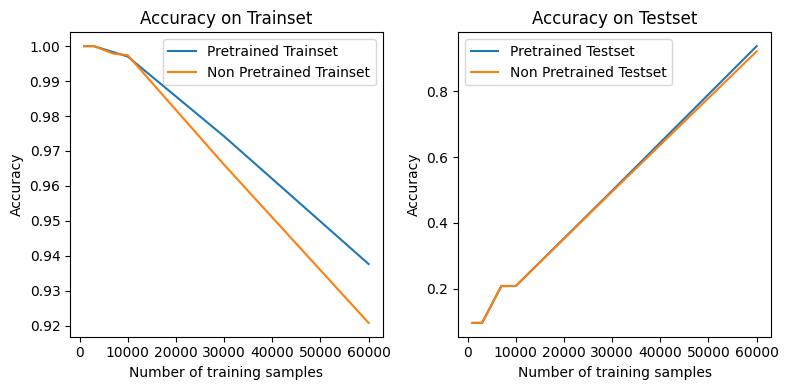

In [12]:
n_train_samples_list = [1000, 3000, 7000, 10000, 30000, 60000]
acc_pretrained_trainset_list = []
acc_non_pretrained_trainset_list = []
acc_pretrained_testset_list = []
acc_non_pretrained_testset_list = []

for i in range(len(n_train_samples_list)):
    set_baseline_hyperparams()
    n_train_samples = n_train_samples_list[i]
    print(f"Training with {n_train_samples} train samples")

    x = x[:n_train_samples]
    y = y[:n_train_samples]

    dbn_pretrained = DNN(n_visible + n_hidden)
    dbn_non_pretrained = deepcopy(dbn_pretrained)

    # print("Start Pretraining dbn_pretrained")
    dbn_pretrained.pretrain(
        x,
        lr=lr_pretrain,
        batch_size=batch_size,
        nb_iter=nb_iter_pretrain,
        verbose=False,
    )

    # print("Start Training dbn_pretrained")
    acc_pretrained_trainset = dbn_pretrained.retropropagation(
        x, y, lr=lr_train, batch_size=batch_size, nb_iter=nb_iter_train, verbose=False
    )
    print(f"acc_pretrained_trainset: {acc_pretrained_trainset:.4f}")

    # print("Start Training dbn_non_pretrained")
    acc_non_pretrained_trainset = dbn_non_pretrained.retropropagation(
        x, y, lr=lr_train, batch_size=batch_size, nb_iter=nb_iter_train, verbose=False
    )
    print(f"acc_non_pretrained_trainset: {acc_non_pretrained_trainset:.4f}")

    # print("Start Testing dbn_pretrained")
    acc_pretrained_testset = dbn_pretrained.test(
        x_test, y_test, batch_size, verbose=False
    )
    print(f"acc_pretrained_testset: {acc_pretrained_testset:.4f}")

    # print("Start Testing dbn_non_pretrained")
    acc_non_pretrained_testset = dbn_non_pretrained.test(
        x_test, y_test, batch_size, verbose=False
    )
    print(f"acc_non_pretrained_testset: {acc_non_pretrained_testset:.4f}")

    acc_pretrained_trainset_list.append(acc_pretrained_trainset)
    acc_non_pretrained_trainset_list.append(acc_non_pretrained_trainset)
    acc_pretrained_testset_list.append(acc_pretrained_testset)
    acc_non_pretrained_testset_list.append(acc_non_pretrained_testset)

    print("\n" + "-" * 50 + "\n")


plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(
    n_train_samples_list, acc_pretrained_trainset_list, label="Pretrained Trainset"
)
plt.plot(
    n_train_samples_list,
    acc_non_pretrained_trainset_list,
    label="Non Pretrained Trainset",
)
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy on Trainset")

plt.subplot(1, 2, 2)
plt.plot(n_train_samples_list, acc_pretrained_testset_list, label="Pretrained Testset")
plt.plot(
    n_train_samples_list,
    acc_non_pretrained_testset_list,
    label="Non Pretrained Testset",
)
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy on Testset")

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<b>Commentaire</b>

1. Généralement, les modèles pré-entraînés + entraînés surpassent les modèles uniquement entraînés.
2. Lorsque la quantité de données d'entraînement est trop faible, il est facile pour le modèle de surajuster et de ne pas généraliser, ce qui entraîne une précision très faible sur l'ensemble de test. À mesure que la quantité de données d'entraînement augmente, la performance des modèles pré-entraînés + entraînés devient supérieure à celle des modèles uniquement entraînés, tant sur l'ensemble d'entraînement que sur l'ensemble de test.

<div class="alert alert-block alert-info">
<b>Commentaire</b>

Les expériences ci-dessus montrent que les modèles pré-entraînés + entraînés peuvent bénéficier de l'augmentation du nombre d'échantillons d'entraînement, de l'ajout de couches cachées et de l'accroissement du nombre de neurones. La meilleure précision que nous avons obtenue est de 0.9586, résultat atteint avec 2 couches cachées (hors couche de classification) et 512 neurones par couche.